In [3]:
%load_ext autoreload
%autoreload 2

In [18]:
!pip install torch scikit-learn pandas nltk matplotlib flwr datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 7.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.3/417.3 kB 8.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.7/390.7 kB 5.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 4.7 MB/s eta 0:00:00
  Using cached async_timeout-4.0.3-py3-none-any.whl (5.7 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1

[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run

In [4]:
import numpy as np
import torch as torch

np.random.seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE} using PyTorch {torch.__version__}")

Training on cpu using PyTorch 2.4.0


In [35]:
import torch
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from nltk.corpus import reuters
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import nltk
from nltk.lm import Vocabulary

class ReutersDataset(Dataset):
    def __init__(self, texts: list[list[int]], labels: list[int]):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int):
        text = torch.tensor(self.texts[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text, label


def load_dataset():
    nltk.download("reuters")
    nltk.download("stopwords")
    nltk.download("punkt")

    # Load documents and their categories
    documents = reuters.fileids()
    categories = [reuters.categories(fileid) for fileid in documents]

    # Load document content
    data = [reuters.raw(fileid) for fileid in documents]

    text = _remove_stopwords(data)
    tokens = [nltk.word_tokenize(sentence) for sentence in text]

    # Flatten the list of tokens for vocabulary creation
    flat_tokens = [token for sentence in tokens for token in sentence]
    vocab = Vocabulary(flat_tokens)

    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(_process_labels(categories))

    encoded_texts = [[vocab[token] for token in sentence] for sentence in tokens]

    encoded_df = pd.DataFrame({
        "text": encoded_texts,
        "category": labels,
    })

    return encoded_df, vocab, label_encoder


def to_dataloader(text: pd.Series, labels: pd.Series, shuffle: bool = True) -> DataLoader:
    dataset = ReutersDataset(text.tolist(), labels.tolist())
    return DataLoader(
        dataset,
        batch_size=32,
        shuffle=shuffle,
        collate_fn=_collate_fn,
    )


def _collate_fn(batch: list[tuple[list[int], list[int]]]):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=-1)
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded, labels


def _remove_stopwords(text: list[str]) -> pd.Series:
    stop = set(nltk.corpus.stopwords.words("english"))
    return (
        pd.Series(text)
        .str.lower()
        .replace("[^\w\s]", "", regex=True)
        .apply(nltk.word_tokenize)
        .apply(lambda sentence: " ".join([word for word in sentence if word not in stop]))
    )


def _process_labels(labels: list[list[str]]) -> pd.Series:
    return pd.Series(labels).apply(lambda x: x[0] if x else "unknown")


In [36]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Load the dataset
df, vocab, label_encoder = load_dataset()

# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["category"], test_size=0.2, random_state=42
)

train_loader = to_dataloader(train_texts, train_labels)
test_loader = to_dataloader(test_texts, test_labels, shuffle=False)

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
from torch import nn
import torch


class TextRNN(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        output_size: int,
        padding_idx: int,
        embed_size=128,
        hidden_size=256,
        num_layers=2,
        dropout=0.5,
    ):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.rnn(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        out = self.dropout(hidden)
        out = self.fc(out)
        return out

In [38]:
# Model hyperparameters
vocab_size = len(vocab)
output_size = len(label_encoder.classes_)

model = TextRNN(
    vocab_size,
    output_size,
    padding_idx=vocab["<pad>"],
).to(DEVICE)

In [39]:
import torch.optim as optim
from torch import nn
from tqdm import tqdm


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    num_epochs: int,
    optimizer: optim.Optimizer,
    verbose=False,
):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()

    model.train()

    for epoch in tqdm(range(num_epochs)):
        for texts, labels in train_loader:
            texts, labels = texts.to(DEVICE), labels.to(DEVICE)

            outputs = model(texts)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


# train_model(model, train_loader, num_epochs=5, verbose=True)

In [ ]:
def evaluate_model(model: nn.Module, test_loader: DataLoader):
    model.eval()

    total, correct = 0, 0

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(DEVICE), labels.to(DEVICE)

            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)

            labels = labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    print(f"Accuracy: {accuracy * 100:.2f}%")


evaluate_model(model, test_loader)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

def run_centralised(epochs: int, lr: float, momentum: float = 0.9):
    model = model = TextRNN(
    vocab_size,
    output_size,
    padding_idx=vocab["<pad>"],
    ).to(DEVICE)
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    #trainloader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=collate_fn)
    #testloader = DataLoader(testset, batch_size=128, collate_fn=collate_fn)

    trained_model = train_model(model, train_loader, epochs, optim, False)
    loss, accuracy = evaluate_model(trained_model, test_loader)
    print(f"{loss = }")
    print(f"{accuracy = }")

run_centralised(epochs=5, lr=0.01)

In [28]:
import torch
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from nltk.corpus import reuters
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import nltk
from nltk.lm import Vocabulary
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import numpy as np
import torch as torch

np.random.seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE} using PyTorch {torch.__version__}")

class ReutersDataset(Dataset):
    def __init__(self, texts: list[list[int]], labels: list[int], maxlen: int):
        self.texts = [text[:maxlen] for text in texts]
        self.labels = labels
        self.maxlen = maxlen

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int):
        text = torch.tensor(self.texts[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text, label


def load_dataset(maxlen: int):
    nltk.download("reuters")
    nltk.download("stopwords")
    nltk.download("punkt")

    # Load documents and their categories
    documents = reuters.fileids()
    categories = [reuters.categories(fileid) for fileid in documents]

    # Load document content
    data = [reuters.raw(fileid) for fileid in documents]

    text = _remove_stopwords(data)
    tokens = [nltk.word_tokenize(sentence) for sentence in text]

    # Flatten the list of tokens for vocabulary creation
    flat_tokens = [token for sentence in tokens for token in sentence]
    vocab = Vocabulary(flat_tokens)

    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(_process_labels(categories))

    # Add a padding token to the vocabulary
    vocab.update(["<pad>"])
    encoded_texts = [[vocab[token] for token in sentence] for sentence in tokens]

    # Apply maxlen to encoded texts
    encoded_texts = [text[:maxlen] for text in encoded_texts]

    encoded_df = pd.DataFrame({
        "text": encoded_texts,
        "category": labels,
    })

    return encoded_df, vocab, label_encoder


def to_dataloader(text: pd.Series, labels: pd.Series, vocab: Vocabulary, maxlen: int, shuffle: bool = True) -> DataLoader:
    dataset = ReutersDataset(text.tolist(), labels.tolist(), maxlen)
    return DataLoader(
        dataset,
        batch_size=32,
        shuffle=shuffle,
        collate_fn=lambda x: _collate_fn(x, vocab),
    )


def _collate_fn(batch: list[tuple[list[int], list[int]]], vocab: Vocabulary):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded, labels


def _remove_stopwords(text: list[str]) -> pd.Series:
    stop = set(nltk.corpus.stopwords.words("english"))
    return (
        pd.Series(text)
        .str.lower()
        .replace("[^\w\s]", "", regex=True)
        .apply(nltk.word_tokenize)
        .apply(lambda sentence: " ".join([word for word in sentence if word not in stop]))
    )


def _process_labels(labels: list[list[str]]) -> pd.Series:
    return pd.Series(labels).apply(lambda x: x[0] if x else "unknown")

# Set the max length for sequences
maxlen = 60

# Load the dataset
df, vocab, label_encoder = load_dataset(maxlen)

# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["category"], test_size=0.2, random_state=42
)

train_loader = to_dataloader(train_texts, train_labels, vocab, maxlen)
test_loader = to_dataloader(test_texts, test_labels, vocab, maxlen, shuffle=False)

from torch import nn

class TextRNN(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        output_size: int,
        padding_idx: int,
        embed_size=128,
        hidden_size=256,
        num_layers=2,
        dropout=0.5,
    ):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            # bidirectional=True,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.rnn(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        out = self.dropout(hidden)
        out = self.fc(out)
        return out

# Model hyperparameters
vocab_size = len(vocab)
output_size = len(label_encoder.classes_)

model = TextRNN(
    vocab_size,
    output_size,
    padding_idx=vocab["<pad>"],
).to(DEVICE)


def evaluate_model(model: nn.Module, test_loader: DataLoader):
    criterion = nn.CrossEntropyLoss()
    model.eval()

    total, correct = 0, 0
    total_loss = 0

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(DEVICE), labels.to(DEVICE)

            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    total_loss /= len(test_loader)
    accuracy = correct / total

    print(f"Test Loss: {total_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

    return total_loss, accuracy

def run_centralised(epochs: int, lr: float, momentum: float = 0.9):
    model = TextRNN(
        vocab_size,
        output_size,
        padding_idx=vocab["<pad>"],
    ).to(DEVICE)
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    history = train_model(model, train_loader, test_loader, epochs, optim, False)
    evaluate_model(model, test_loader)
    return history

history = run_centralised(epochs=20, lr=0.01)


<>:128: DeprecationWarning: invalid escape sequence \w
[nltk_data] Downloading package reuters to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Training on cpu using PyTorch 2.4.0


  5%|▌         | 1/20 [00:19<06:10, 19.51s/it]

Test Loss: 2.4348, Test Accuracy: 37.03%


 10%|█         | 2/20 [00:38<05:40, 18.92s/it]

Test Loss: 2.1022, Test Accuracy: 50.42%


 15%|█▌        | 3/20 [00:55<05:07, 18.08s/it]

Test Loss: 2.2855, Test Accuracy: 41.52%


 20%|██        | 4/20 [01:14<04:59, 18.71s/it]

Test Loss: 2.3988, Test Accuracy: 39.43%


 25%|██▌       | 5/20 [01:33<04:40, 18.71s/it]

Test Loss: 2.2109, Test Accuracy: 47.73%


 30%|███       | 6/20 [01:49<04:10, 17.90s/it]

Test Loss: 2.2925, Test Accuracy: 44.76%


 35%|███▌      | 7/20 [02:06<03:46, 17.40s/it]

Test Loss: 2.1614, Test Accuracy: 47.08%


 40%|████      | 8/20 [02:23<03:28, 17.35s/it]

Test Loss: 2.5754, Test Accuracy: 44.62%


 45%|████▌     | 9/20 [02:39<03:06, 16.95s/it]

Test Loss: 2.0417, Test Accuracy: 50.74%


 50%|█████     | 10/20 [02:55<02:46, 16.63s/it]

Test Loss: 1.7207, Test Accuracy: 58.25%


 55%|█████▌    | 11/20 [03:12<02:31, 16.85s/it]

Test Loss: 1.5213, Test Accuracy: 63.90%


 60%|██████    | 12/20 [03:29<02:13, 16.73s/it]

Test Loss: 1.4479, Test Accuracy: 64.64%


 65%|██████▌   | 13/20 [03:45<01:56, 16.69s/it]

Test Loss: 1.3034, Test Accuracy: 67.75%


 70%|███████   | 14/20 [04:02<01:39, 16.58s/it]

Test Loss: 1.1499, Test Accuracy: 70.34%


 75%|███████▌  | 15/20 [04:19<01:24, 16.96s/it]

Test Loss: 1.0437, Test Accuracy: 72.89%


 80%|████████  | 16/20 [04:36<01:07, 16.76s/it]

Test Loss: 1.0420, Test Accuracy: 73.22%


 85%|████████▌ | 17/20 [04:52<00:49, 16.54s/it]

Test Loss: 1.0022, Test Accuracy: 74.10%


 90%|█████████ | 18/20 [05:10<00:34, 17.16s/it]

Test Loss: 0.9228, Test Accuracy: 76.32%


 95%|█████████▌| 19/20 [05:27<00:16, 16.86s/it]

Test Loss: 0.9393, Test Accuracy: 77.11%


100%|██████████| 20/20 [05:42<00:00, 17.14s/it]

Test Loss: 0.8950, Test Accuracy: 77.25%


Test Loss: 0.8950, Test Accuracy: 77.25%


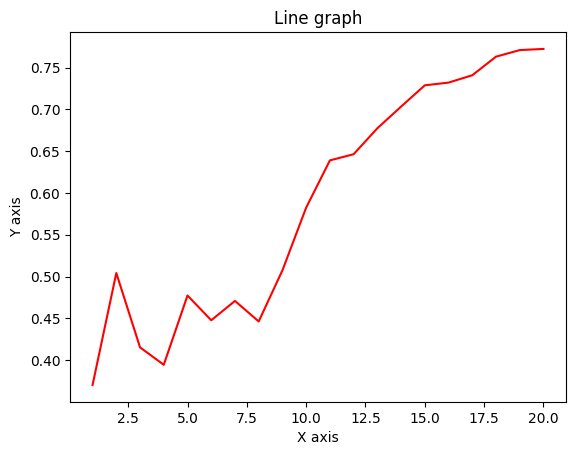

In [32]:
plt.title("Line graph") 
plt.xlabel("X axis") 
plt.ylabel("Y axis") 
plt.plot(range(1, len(history["train_accuracy"])+1), history["train_accuracy"], color ="red") 
plt.show()

In [49]:
num_clients = 100

In [50]:
import torch
from torch.utils.data import DataLoader, random_split, Subset

def prepare_dataset(num_partitions: int, batch_size: int, val_ratio: float = 0.1):
    """This function partitions the training set into N disjoint
    subsets, each will become the local dataset of a client. This
    function also subsequently partitions each training set partition
    into train and validation. The test set is left intact and will
    be used by the central server to assess the performance of the
    global model."""

    # Extract dataset from DataLoader
    train_dataset = train_loader.dataset
    test_dataset = test_loader.dataset

    # Calculate partition lengths
    num_images = len(train_dataset)
    partition_len = [num_images // num_partitions] * num_partitions
    partition_len[-1] += num_images % num_partitions  # Add remainder to the last partition

    # Split the dataset into `num_partitions`
    trainsets = random_split(train_dataset, partition_len, torch.Generator().manual_seed(2023))

    # Create DataLoaders with train+val support
    trainloaders = []
    valloaders = []
    for trainset in trainsets:
        num_total = len(trainset)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        train_subset, val_subset = random_split(trainset, [num_train, num_val], torch.Generator().manual_seed(2023))

        trainloaders.append(DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=lambda x: _collate_fn(x, vocab)))
        valloaders.append(DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=lambda x: _collate_fn(x, vocab)))

    # Create DataLoader for the test set
    testloader = DataLoader(test_dataset, batch_size=128, collate_fn=lambda x: _collate_fn(x, vocab))

    return trainloaders, valloaders, testloader

# Example usage:
num_partitions = 5
batch_size = 32
trainloaders, valloaders, testloader = prepare_dataset(num_partitions, batch_size)

number of images: 78


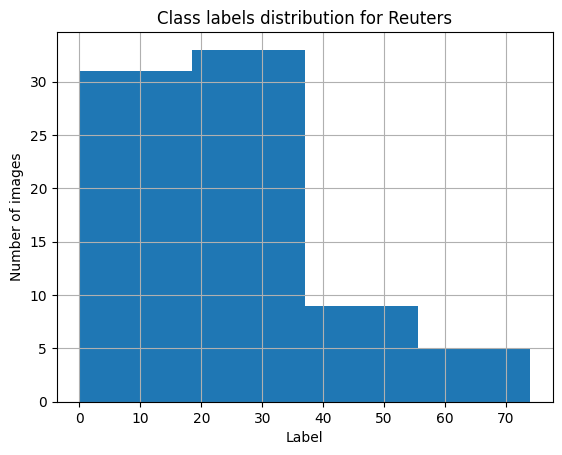

In [51]:
import matplotlib.pyplot as plt
trainloaders, valloaders, testloader = prepare_dataset(num_partitions=num_clients, batch_size=8)

# first partition
train_partition = trainloaders[1].dataset

# count data points
partition_indices = train_partition.indices
print(f"number of images: {len(partition_indices)}")

# visualise histogram
plt.hist([train_partition.dataset[idx][1].item() for idx in partition_indices], bins=4)  # 46 classes in Reuters dataset
plt.grid()
plt.xlabel("Label")
plt.ylabel("Number of images")
plt.title("Class labels distribution for Reuters")
plt.show()

In [52]:
import flwr as fl

In [53]:
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = TextRNN(
            vocab_size,
            output_size,
            padding_idx=vocab["<pad>"],
        ).to(DEVICE)

    def set_parameters(self, parameters):
        """With the model parameters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and convert them to a list of
        NumPy arrays. The server doesn't work with PyTorch/TF/etc."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        # Define the optimizer -------------------------------------------------------------- Essentially the same as in the centralised example above
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # do local training  -------------------------------------------------------------- Essentially the same as in the centralised example above (but now using the client's data instead of the whole dataset)
        train_model(model=self.model, train_loader=self.trainloader, test_loader=self.valloader, num_epochs=1, optimizer=optim, verbose=False)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = evaluate_model(
            self.model, self.valloader
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting (but this time using the client's local validation set)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-07-29 23:23:52,586	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 8433413325.0, 'CPU': 10.0, 'object_store_memory': 2147483648.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 10 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You ca

Test Loss: 4.3587, Test Accuracy: 0.65%


(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50143) 
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50143)             entirely in future versions of Flower.
(ClientAppActor pid=50143)         
100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50143) 
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50143)             entirely in futur

(ClientAppActor pid=50143) Test Loss: 4.2593, Test Accuracy: 25.00%


  0%|          | 0/1 [00:00<?, ?it/s]


(ClientAppActor pid=50143) Test Loss: 4.2634, Test Accuracy: 12.50%


  0%|          | 0/1 [00:00<?, ?it/s]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 9x across cluster]
(ClientAppActor pid=50135)          [repeated 19x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 9x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 9x across cluster]


(ClientAppActor pid=50143) Test Loss: 4.2407, Test Accuracy: 37.50%


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 2x across cluster]


(ClientAppActor pid=50142) Test Loss: 4.3282, Test Accuracy: 12.50%
(ClientAppActor pid=50140) Test Loss: 4.2520, Test Accuracy: 25.00%


(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
100%|██████████| 1/1 [00:01<00:00,  1.92s/it] [repeated 13x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 4x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50141) 
(ClientAppActor pid=50140) Test Loss: 4.2688, Test Accuracy: 18.18% [repeated 23x across cluster]


(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
100%|██████████| 1/1 [00:01<00:00,  1.23s/it] [repeated 79x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 26x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50143) Test Loss: 4.2556, Test Accuracy: 25.00% [repeated 22x across cluster]


(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 22x across cluster]
100%|██████████| 1/1 [00:01<00:00,  1.39s/it] [repeated 66x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 22x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 22x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]


(ClientAppActor pid=50141) Test Loss: 4.2793, Test Accuracy: 12.50% [repeated 20x across cluster]


(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 19x across cluster]
100%|██████████| 1/1 [00:01<00:00,  1.47s/it] [repeated 59x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 19x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 19x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]


(ClientAppActor pid=50138) Test Loss: 4.1839, Test Accuracy: 62.50% [repeated 19x across cluster]


(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 18x across cluster]
100%|██████████| 1/1 [00:01<00:00,  1.63s/it] [repeated 55x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 18x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 18x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (1, 4.245385198032155, {'accuracy': 0.3614457831325301}, 37.6600547500002)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 4.2454, Test Accuracy: 36.14%


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 7x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50141)          [repeated 8x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50141)             entirely in future versions of Flower.
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50138)             entirely in future vers

(ClientAppActor pid=50141) Test Loss: 4.2236, Test Accuracy: 37.50% [repeated 12x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]
(ClientAppActor pid=50141)          [repeated 63x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 28x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 28x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 28x across cluster]


(ClientAppActor pid=50142) Test Loss: 4.1649, Test Accuracy: 37.50% [repeated 25x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.34s/it] [repeated 58x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 20x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 20x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 20x across cluster]


(ClientAppActor pid=50139) Test Loss: 4.1334, Test Accuracy: 37.50% [repeated 19x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]
(ClientAppActor pid=50138)          [repeated 61x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 21x across cluster]


(ClientAppActor pid=50139) Test Loss: 4.1431, Test Accuracy: 37.50% [repeated 19x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.30s/it] [repeated 65x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 21x across cluster]


(ClientAppActor pid=50143) Test Loss: 4.1376, Test Accuracy: 37.50% [repeated 26x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]
(ClientAppActor pid=50141)          [repeated 70x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 24x across cluster]


(ClientAppActor pid=50142) Test Loss: 4.0105, Test Accuracy: 75.00% [repeated 25x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 4x across cluster]
(ClientAppActor pid=50143)          [repeated 20x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 4x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures


(ClientAppActor pid=50143) Test Loss: 4.2248, Test Accuracy: 25.00% [repeated 5x across cluster]


INFO :      fit progress: (2, 4.130982511183795, {'accuracy': 0.3614457831325301}, 77.42237699999987)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 4.1310, Test Accuracy: 36.14%


  0%|          | 0/1 [00:00<?, ?it/s]
(ClientAppActor pid=50143)          [repeated 3x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50143)             entirely in future versions of Flower.
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50137)             entirely in future versions of Flower.


(ClientAppActor pid=50137) Test Loss: 4.0302, Test Accuracy: 50.00%
(ClientAppActor pid=50143) Test Loss: 3.9642, Test Accuracy: 75.00%


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
  0%|          | 0/1 [00:00<?, ?it/s]
(ClientAppActor pid=50143)          [repeated 93x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 39x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 39x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 39x across cluster]


(ClientAppActor pid=50134) Test Loss: 3.8653, Test Accuracy: 62.50% [repeated 33x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.17s/it] [repeated 57x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 18x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 18x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 18x across cluster]


(ClientAppActor pid=50143) Test Loss: 4.0904, Test Accuracy: 25.00% [repeated 19x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.12s/it] [repeated 74x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 25x across cluster]


(ClientAppActor pid=50140) Test Loss: 4.0578, Test Accuracy: 37.50% [repeated 24x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.32s/it] [repeated 73x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 24x across cluster]


(ClientAppActor pid=50134) Test Loss: 4.0831, Test Accuracy: 25.00% [repeated 25x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]


(ClientAppActor pid=50137) 


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (3, 4.011868364670697, {'accuracy': 0.3614457831325301}, 109.95005687499997)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 4.0119, Test Accuracy: 36.14%


(ClientAppActor pid=50143)          [repeated 46x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 13x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 13x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 13x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 7x across cluster]


(ClientAppActor pid=50143) Test Loss: 4.0465, Test Accuracy: 25.00% [repeated 18x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50143)          [repeated 106x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 44x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 44x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 44x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50135) Test Loss: 3.8698, Test Accuracy: 25.00% [repeated 38x across cluster]


(ClientAppActor pid=50143)          [repeated 72x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50142) Test Loss: 4.0276, Test Accuracy: 25.00% [repeated 23x across cluster]


(ClientAppActor pid=50139)          [repeated 53x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 17x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 17x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 17x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]


(ClientAppActor pid=50136) Test Loss: 3.6186, Test Accuracy: 62.50% [repeated 19x across cluster]


(ClientAppActor pid=50137)          [repeated 59x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 20x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 20x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 20x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]


(ClientAppActor pid=50141) Test Loss: 3.9788, Test Accuracy: 37.50% [repeated 19x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (4, 3.883441925048828, {'accuracy': 0.3614457831325301}, 143.9223909579996)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 3.8834, Test Accuracy: 36.14%


(ClientAppActor pid=50135)          [repeated 52x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 15x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 16x across cluster]


(ClientAppActor pid=50135) Test Loss: 4.1042, Test Accuracy: 12.50% [repeated 21x across cluster]
(ClientAppActor pid=50140) 


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50142)          [repeated 76x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 33x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 33x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 33x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(ClientAppActor pid=50143) Test Loss: 3.4110, Test Accuracy: 75.00% [repeated 30x across cluster]


(ClientAppActor pid=50138)          [repeated 57x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 20x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 20x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 20x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]


(ClientAppActor pid=50142) Test Loss: 3.6971, Test Accuracy: 37.50% [repeated 23x across cluster]
(ClientAppActor pid=50140) 


(ClientAppActor pid=50135)          [repeated 59x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 19x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 19x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 19x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]


(ClientAppActor pid=50135) Test Loss: 3.8157, Test Accuracy: 25.00% [repeated 19x across cluster]


(ClientAppActor pid=50139)          [repeated 73x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 25x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50142) Test Loss: 3.5116, Test Accuracy: 50.00% [repeated 23x across cluster]


(ClientAppActor pid=50135)          [repeated 57x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 18x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 18x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 18x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]


(ClientAppActor pid=50141) 


INFO :      aggregate_fit: received 100 results and 0 failures


(ClientAppActor pid=50138) Test Loss: 3.7648, Test Accuracy: 37.50% [repeated 22x across cluster]


INFO :      fit progress: (5, 3.7406014133902157, {'accuracy': 0.3614457831325301}, 178.89157287499984)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 3.7406, Test Accuracy: 36.14%


(ClientAppActor pid=50134)          [repeated 20x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 5x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 5x across cluster]


(ClientAppActor pid=50134) Test Loss: 3.7753, Test Accuracy: 37.50% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.23s/it] [repeated 105x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 43x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 43x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 43x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50141) Test Loss: 3.4813, Test Accuracy: 37.50% [repeated 39x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.18s/it] [repeated 51x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 17x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 17x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 17x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 15x across cluster]


(ClientAppActor pid=50136) Test Loss: 3.6338, Test Accuracy: 37.50% [repeated 16x across cluster]


(ClientAppActor pid=50135)          [repeated 67x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 22x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 22x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 22x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50138) Test Loss: 3.7073, Test Accuracy: 25.00% [repeated 23x across cluster]
(ClientAppActor pid=50140) 


100%|██████████| 1/1 [00:01<00:00,  1.36s/it] [repeated 66x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 22x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 22x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 22x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50143) Test Loss: 3.1337, Test Accuracy: 62.50% [repeated 24x across cluster]
(ClientAppActor pid=50137) 


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (6, 3.5769890196183147, {'accuracy': 0.3614457831325301}, 209.59223399999973)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 3.5770, Test Accuracy: 36.14%


(ClientAppActor pid=50137)          [repeated 53x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 16x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 16x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 16x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 15x across cluster]


(ClientAppActor pid=50137) Test Loss: 3.8164, Test Accuracy: 25.00% [repeated 18x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50137)          [repeated 86x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 38x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 38x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 38x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 16x across cluster]


(ClientAppActor pid=50142) Test Loss: 3.4228, Test Accuracy: 37.50% [repeated 30x across cluster]


(ClientAppActor pid=50139)          [repeated 59x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 20x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 20x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 20x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]


(ClientAppActor pid=50134) Test Loss: 3.3055, Test Accuracy: 25.00% [repeated 21x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.35s/it] [repeated 61x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 19x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 19x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 19x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]


(ClientAppActor pid=50137) Test Loss: 3.4362, Test Accuracy: 25.00% [repeated 26x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.22s/it] [repeated 74x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 25x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]


(ClientAppActor pid=50138) Test Loss: 3.3118, Test Accuracy: 37.50% [repeated 21x across cluster]


100%|██████████| 1/1 [00:00<00:00,  1.79it/s] [repeated 58x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 17x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 17x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 17x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 17x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (7, 3.3863807986764347, {'accuracy': 0.3614457831325301}, 241.02642520799964)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 3.3864, Test Accuracy: 36.14%


(ClientAppActor pid=50142)          [repeated 3x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50142)             entirely in future versions of Flower.
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50135)             entirely in future versions of Flower.


(ClientAppActor pid=50142) Test Loss: 3.3799, Test Accuracy: 25.00% [repeated 22x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
  0%|          | 0/1 [00:00<?, ?it/s]
(ClientAppActor pid=50141)          [repeated 84x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 37x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 37x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 37x across cluster]


(ClientAppActor pid=50138) Test Loss: 3.8293, Test Accuracy: 25.00% [repeated 30x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 19x across cluster]
(ClientAppActor pid=50142)          [repeated 71x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 23x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.9309, Test Accuracy: 50.00% [repeated 27x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.20s/it] [repeated 78x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 25x across cluster]


(ClientAppActor pid=50137) Test Loss: 2.7034, Test Accuracy: 50.00% [repeated 25x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]
(ClientAppActor pid=50135)          [repeated 68x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 23x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.8211, Test Accuracy: 37.50% [repeated 23x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (8, 3.177382511251113, {'accuracy': 0.3614457831325301}, 272.45118899999943)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 3.1774, Test Accuracy: 36.14%


(ClientAppActor pid=50136)          [repeated 40x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 11x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 11x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 11x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 7x across cluster]


(ClientAppActor pid=50140) Test Loss: 3.6010, Test Accuracy: 12.50% [repeated 15x across cluster]
(ClientAppActor pid=50143) 


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50139)          [repeated 107x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 44x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 44x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 44x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50138) Test Loss: 1.9009, Test Accuracy: 75.00% [repeated 39x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.10s/it] [repeated 69x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 26x across cluster]


(ClientAppActor pid=50135) Test Loss: 2.8521, Test Accuracy: 37.50% [repeated 27x across cluster]


(ClientAppActor pid=50139)          [repeated 81x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 26x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.0299, Test Accuracy: 62.50% [repeated 23x across cluster]


(ClientAppActor pid=50143)          [repeated 71x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 23x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50137) Test Loss: 3.8212, Test Accuracy: 25.00% [repeated 25x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (9, 2.9850692608777214, {'accuracy': 0.3614457831325301}, 300.87664824999956)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.9851, Test Accuracy: 36.14%


(ClientAppActor pid=50136)          [repeated 14x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 3x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 4x across cluster]


(ClientAppActor pid=50138) Test Loss: 3.2072, Test Accuracy: 25.00% [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50136)          [repeated 69x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 32x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 32x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 32x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(ClientAppActor pid=50143) Test Loss: 2.9982, Test Accuracy: 37.50% [repeated 26x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.24s/it] [repeated 64x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 20x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 20x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 20x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]


(ClientAppActor pid=50135) Test Loss: 3.2399, Test Accuracy: 25.00% [repeated 25x across cluster]
(ClientAppActor pid=50142) 


(ClientAppActor pid=50142)          [repeated 78x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 27x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 27x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 27x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 28x across cluster]


(ClientAppActor pid=50142) Test Loss: 1.8762, Test Accuracy: 62.50% [repeated 28x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.24s/it] [repeated 73x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 23x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50143) Test Loss: 2.7395, Test Accuracy: 37.50% [repeated 22x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
100%|██████████| 1/1 [00:00<00:00,  2.01it/s] [repeated 58x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 17x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 17x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 17x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]
INFO :      fit progress: (10, 2.859927962808048, {'accuracy': 0.3614457831325301}, 336.10885849999977)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.8599, Test Accuracy: 36.14%


(ClientAppActor pid=50139)          [repeated 2x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50139)             entirely in future versions of Flower.
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50141)             entirely in future versions of Flower.


(ClientAppActor pid=50139) Test Loss: 3.0944, Test Accuracy: 25.00% [repeated 19x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  2.00s/it] [repeated 66x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 31x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 31x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 31x across cluster]


(ClientAppActor pid=50135) Test Loss: 2.8577, Test Accuracy: 50.00% [repeated 27x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 17x across cluster]


(ClientAppActor pid=50141) 


100%|██████████| 1/1 [00:01<00:00,  1.30s/it] [repeated 67x across cluster]


(ClientAppActor pid=50137) Test Loss: 3.0097, Test Accuracy: 37.50% [repeated 20x across cluster]


(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 21x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]
(ClientAppActor pid=50142)          [repeated 73x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50136)  

(ClientAppActor pid=50141) Test Loss: 3.2251, Test Accuracy: 25.00% [repeated 26x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.38s/it] [repeated 68x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 23x across cluster]


(ClientAppActor pid=50142) Test Loss: 2.4874, Test Accuracy: 37.50% [repeated 23x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (11, 2.792671862770529, {'accuracy': 0.3614457831325301}, 369.3438962909995)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.7927, Test Accuracy: 36.14%


(ClientAppActor pid=50143)          [repeated 66x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 18x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 18x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 18x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(ClientAppActor pid=50143) Test Loss: 2.4456, Test Accuracy: 62.50% [repeated 24x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50137)          [repeated 78x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 35x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 35x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 35x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 15x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.0401, Test Accuracy: 62.50% [repeated 28x across cluster]
(ClientAppActor pid=50140) 


100%|██████████| 1/1 [00:01<00:00,  1.13s/it] [repeated 75x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50142) Test Loss: 4.1229, Test Accuracy: 12.50% [repeated 26x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.51s/it] [repeated 69x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]


(ClientAppActor pid=50134) Test Loss: 1.6089, Test Accuracy: 75.00% [repeated 29x across cluster]


(ClientAppActor pid=50137)          [repeated 86x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 29x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 29x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 29x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 27x across cluster]


(ClientAppActor pid=50136) 
(ClientAppActor pid=50142) Test Loss: 1.6708, Test Accuracy: 62.50% [repeated 22x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (12, 2.7530276074128994, {'accuracy': 0.3614457831325301}, 399.04645866600004)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.7530, Test Accuracy: 36.14%


(ClientAppActor pid=50143)          [repeated 33x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 8x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(ClientAppActor pid=50143) Test Loss: 3.6622, Test Accuracy: 12.50% [repeated 15x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50142)          [repeated 94x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 40x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 40x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 40x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]


(ClientAppActor pid=50137) Test Loss: 2.9389, Test Accuracy: 37.50% [repeated 35x across cluster]


(ClientAppActor pid=50140)          [repeated 64x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 21x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]


(ClientAppActor pid=50142) Test Loss: 3.0715, Test Accuracy: 37.50% [repeated 21x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.10s/it] [repeated 74x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 25x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 27x across cluster]


(ClientAppActor pid=50143) Test Loss: 3.2091, Test Accuracy: 18.18% [repeated 23x across cluster]
(ClientAppActor pid=50140) 


100%|██████████| 1/1 [00:01<00:00,  1.38s/it] [repeated 76x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50137) Test Loss: 2.2338, Test Accuracy: 25.00% [repeated 28x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (13, 2.728297696394079, {'accuracy': 0.3614457831325301}, 431.3594514159995)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.7283, Test Accuracy: 36.14%


(ClientAppActor pid=50141)          [repeated 34x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 10x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 10x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(ClientAppActor pid=50143) Test Loss: 2.4967, Test Accuracy: 62.50% [repeated 13x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50138)          [repeated 80x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 36x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 36x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 36x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 14x across cluster]


(ClientAppActor pid=50142) Test Loss: 2.4008, Test Accuracy: 62.50% [repeated 28x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.08s/it] [repeated 57x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 18x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 18x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 18x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]


(ClientAppActor pid=50134) Test Loss: 3.1624, Test Accuracy: 18.18% [repeated 22x across cluster]


(ClientAppActor pid=50143)          [repeated 60x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 21x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]


(ClientAppActor pid=50135) Test Loss: 3.2452, Test Accuracy: 37.50% [repeated 26x across cluster]


(ClientAppActor pid=50135)          [repeated 59x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 19x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 19x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 19x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 22x across cluster]


(ClientAppActor pid=50137) Test Loss: 3.5957, Test Accuracy: 12.50% [repeated 19x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.76s/it] [repeated 52x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 17x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 17x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 17x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 16x across cluster]


(ClientAppActor pid=50140) Test Loss: 2.6616, Test Accuracy: 37.50% [repeated 15x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.06s/it] [repeated 31x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 8x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (14, 2.709014457814834, {'accuracy': 0.3614457831325301}, 477.0435993330002)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.7090, Test Accuracy: 36.14%


(ClientAppActor pid=50142)          [repeated 2x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50142)             entirely in future versions of Flower.
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50141)             entirely in future versions of Flower.


(ClientAppActor pid=50142) Test Loss: 3.7101, Test Accuracy: 12.50% [repeated 10x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
  0%|          | 0/1 [00:00<?, ?it/s]


(ClientAppActor pid=50141) Test Loss: 1.3904, Test Accuracy: 87.50% [repeated 31x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.16s/it] [repeated 84x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 35x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 35x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 35x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]
(ClientAppActor pid=50142)          [repeated 32x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.commo

(ClientAppActor pid=50141) Test Loss: 2.9450, Test Accuracy: 37.50% [repeated 12x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 7x across cluster]
(ClientAppActor pid=50134)          [repeated 47x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 16x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 16x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 16x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.2899, Test Accuracy: 50.00% [repeated 16x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]
(ClientAppActor pid=50136)          [repeated 40x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 13x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 13x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 13x across cluster]


(ClientAppActor pid=50134) Test Loss: 0.9006, Test Accuracy: 75.00% [repeated 14x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.37s/it] [repeated 61x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 21x across cluster]


(ClientAppActor pid=50134) Test Loss: 3.3221, Test Accuracy: 25.00% [repeated 18x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]
(ClientAppActor pid=50140)          [repeated 53x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 18x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 18x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 18x across cluster]


(ClientAppActor pid=50140) Test Loss: 2.6279, Test Accuracy: 37.50% [repeated 22x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (15, 2.690769027261173, {'accuracy': 0.3614457831325301}, 520.1566234579996)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.6908, Test Accuracy: 36.14%


(ClientAppActor pid=50142)          [repeated 25x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 6x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.7900, Test Accuracy: 25.00% [repeated 7x across cluster]
(ClientAppActor pid=50138) 


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
  0%|          | 0/1 [00:00<?, ?it/s]
(ClientAppActor pid=50139)          [repeated 94x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 40x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 40x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 40x across cluster]


(ClientAppActor pid=50141) Test Loss: 3.6211, Test Accuracy: 12.50% [repeated 34x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 28x across cluster]


(ClientAppActor pid=50134) 


(ClientAppActor pid=50137)          [repeated 82x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 27x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 27x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 27x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.8217, Test Accuracy: 25.00% [repeated 28x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.03s/it] [repeated 76x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 25x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.5011, Test Accuracy: 37.50% [repeated 26x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.09s/it] [repeated 70x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 24x across cluster]


(ClientAppActor pid=50139) Test Loss: 1.5653, Test Accuracy: 62.50% [repeated 26x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (16, 2.6729852592243866, {'accuracy': 0.3614457831325301}, 553.6674197499997)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.6730, Test Accuracy: 36.14%


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 19x across cluster]
(ClientAppActor pid=50134)          [repeated 18x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 4x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.8356, Test Accuracy: 25.00% [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 17x across cluster]
(ClientAppActor pid=50139)          [repeated 88x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 39x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 39x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 39x across cluster]


(ClientAppActor pid=50135) Test Loss: 2.2193, Test Accuracy: 50.00% [repeated 31x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]
(ClientAppActor pid=50143)          [repeated 64x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 20x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 20x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 20x across cluster]


(ClientAppActor pid=50139) Test Loss: 3.7376, Test Accuracy: 12.50% [repeated 25x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.16s/it] [repeated 84x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 28x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 28x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 28x across cluster]


(ClientAppActor pid=50137) Test Loss: 3.1649, Test Accuracy: 37.50% [repeated 25x across cluster]


100%|██████████| 1/1 [00:00<00:00,  1.06it/s] [repeated 75x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 24x across cluster]


(ClientAppActor pid=50136) Test Loss: 3.2269, Test Accuracy: 25.00% [repeated 30x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (17, 2.656201054068173, {'accuracy': 0.3614457831325301}, 585.7615767910002)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.6562, Test Accuracy: 36.14%


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]
(ClientAppActor pid=50142)          [repeated 31x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 9x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 9x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 9x across cluster]


(ClientAppActor pid=50142) Test Loss: 3.4257, Test Accuracy: 12.50% [repeated 9x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


(ClientAppActor pid=50137) Test Loss: 3.1773, Test Accuracy: 25.00% [repeated 31x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.15s/it] [repeated 90x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 39x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 39x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 39x across cluster]


(ClientAppActor pid=50134) 


100%|██████████| 1/1 [00:01<00:00,  1.23s/it] [repeated 80x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 26x across cluster]


(ClientAppActor pid=50141) Test Loss: 2.9534, Test Accuracy: 37.50% [repeated 28x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.16s/it] [repeated 66x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 21x across cluster]


(ClientAppActor pid=50135) Test Loss: 2.4954, Test Accuracy: 50.00% [repeated 25x across cluster]


100%|██████████| 1/1 [00:02<00:00,  2.54s/it] [repeated 45x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 15x across cluster]


(ClientAppActor pid=50143) Test Loss: 2.4352, Test Accuracy: 12.50% [repeated 13x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.52s/it] [repeated 53x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 18x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 18x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 18x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.9494, Test Accuracy: 37.50% [repeated 18x across cluster]
(ClientAppActor pid=50143) 


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (18, 2.639757549061495, {'accuracy': 0.3614457831325301}, 624.8663351659998)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.6398, Test Accuracy: 36.14%


(ClientAppActor pid=50139)          [repeated 7x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50139)             entirely in future versions of Flower.
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50143)             entirely in future versions of Flower.


(ClientAppActor pid=50143) Test Loss: 3.0569, Test Accuracy: 12.50% [repeated 5x across cluster]
(ClientAppActor pid=50135) 


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
  0%|          | 0/1 [00:00<?, ?it/s]
(ClientAppActor pid=50143)          [repeated 80x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 34x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 34x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 34x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.7598, Test Accuracy: 37.50% [repeated 30x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 27x across cluster]
(ClientAppActor pid=50138)          [repeated 78x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 26x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.0199, Test Accuracy: 62.50% [repeated 26x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]
(ClientAppActor pid=50142)          [repeated 66x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 21x across cluster]


(ClientAppActor pid=50143) Test Loss: 1.7104, Test Accuracy: 50.00% [repeated 25x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50138) 


(ClientAppActor pid=50136)          [repeated 71x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 24x across cluster]


(ClientAppActor pid=50142) Test Loss: 3.1677, Test Accuracy: 37.50% [repeated 21x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (19, 2.623872069751515, {'accuracy': 0.3614457831325301}, 660.1351063749999)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.6239, Test Accuracy: 36.14%


(ClientAppActor pid=50143)          [repeated 47x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 14x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 14x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 14x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 6x across cluster]


(ClientAppActor pid=50138) Test Loss: 1.6728, Test Accuracy: 50.00% [repeated 18x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50141)          [repeated 69x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 31x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 31x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 31x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(ClientAppActor pid=50140) Test Loss: 3.1499, Test Accuracy: 37.50% [repeated 27x across cluster]


(ClientAppActor pid=50136)          [repeated 64x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 22x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 22x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 22x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]


(ClientAppActor pid=50134) Test Loss: 3.4220, Test Accuracy: 12.50% [repeated 19x across cluster]


(ClientAppActor pid=50135)          [repeated 76x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 25x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 27x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.7462, Test Accuracy: 12.50% [repeated 28x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.12s/it] [repeated 79x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 26x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 26x across cluster]


(ClientAppActor pid=50138) Test Loss: 3.7830, Test Accuracy: 25.00% [repeated 26x across cluster]
(ClientAppActor pid=50137) 


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (20, 2.609039783477783, {'accuracy': 0.3614457831325301}, 691.0125504580001)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.6090, Test Accuracy: 36.14%


(ClientAppActor pid=50143)          [repeated 55x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 16x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 16x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 16x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 16x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.4888, Test Accuracy: 50.00% [repeated 20x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50134)          [repeated 80x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 35x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 35x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 35x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 15x across cluster]


(ClientAppActor pid=50137) Test Loss: 3.1148, Test Accuracy: 25.00% [repeated 30x across cluster]


(ClientAppActor pid=50140)          [repeated 78x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 27x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 27x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 27x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 28x across cluster]


(ClientAppActor pid=50142) Test Loss: 1.0997, Test Accuracy: 62.50% [repeated 27x across cluster]


(ClientAppActor pid=50142)          [repeated 75x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 25x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 22x across cluster]


(ClientAppActor pid=50138) Test Loss: 3.1652, Test Accuracy: 25.00% [repeated 23x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.37s/it] [repeated 68x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 22x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 22x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 22x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50142) Test Loss: 1.9984, Test Accuracy: 25.00% [repeated 27x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (21, 2.594927942051607, {'accuracy': 0.3614457831325301}, 719.135688583)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.5949, Test Accuracy: 36.14%


(ClientAppActor pid=50138)          [repeated 39x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 11x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 11x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 11x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 12x across cluster]


(ClientAppActor pid=50138) Test Loss: 3.0157, Test Accuracy: 25.00% [repeated 13x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:00<00:00,  1.08it/s] [repeated 86x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 37x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 37x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 37x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]


(ClientAppActor pid=50140) Test Loss: 3.3720, Test Accuracy: 12.50% [repeated 32x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.14s/it] [repeated 52x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 17x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 17x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 17x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 16x across cluster]


(ClientAppActor pid=50136) Test Loss: 1.5777, Test Accuracy: 62.50% [repeated 20x across cluster]


(ClientAppActor pid=50136)          [repeated 82x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 28x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 28x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 28x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 28x across cluster]


(ClientAppActor pid=50135) Test Loss: 3.1670, Test Accuracy: 25.00% [repeated 28x across cluster]


(ClientAppActor pid=50142)          [repeated 80x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 26x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 26x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.9985, Test Accuracy: 25.00% [repeated 27x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (22, 2.5816746599533977, {'accuracy': 0.3614457831325301}, 750.1732582079994)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.5817, Test Accuracy: 36.14%


(ClientAppActor pid=50138)          [repeated 43x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 12x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 12x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 12x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.7237, Test Accuracy: 50.00% [repeated 13x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.13s/it] [repeated 90x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 39x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 39x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 39x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 19x across cluster]


(ClientAppActor pid=50138) Test Loss: 1.8284, Test Accuracy: 37.50% [repeated 34x across cluster]
(ClientAppActor pid=50143) 


(ClientAppActor pid=50139)          [repeated 75x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 25x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.9945, Test Accuracy: 25.00% [repeated 24x across cluster]


(ClientAppActor pid=50140)          [repeated 77x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 25x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]


(ClientAppActor pid=50139) Test Loss: 1.2119, Test Accuracy: 75.00% [repeated 26x across cluster]


(ClientAppActor pid=50134)          [repeated 76x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 26x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50141) Test Loss: 2.6045, Test Accuracy: 25.00% [repeated 25x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (23, 2.5696771705851837, {'accuracy': 0.3614457831325301}, 778.9386216659996)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.5697, Test Accuracy: 36.14%


(ClientAppActor pid=50140)          [repeated 23x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 5x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 7x across cluster]


(ClientAppActor pid=50140) Test Loss: 2.4607, Test Accuracy: 37.50% [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:00<00:00,  1.06it/s] [repeated 97x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 41x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 41x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 41x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]


(ClientAppActor pid=50142) Test Loss: 3.0439, Test Accuracy: 12.50% [repeated 35x across cluster]


(ClientAppActor pid=50142)          [repeated 43x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 14x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 14x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 14x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 15x across cluster]


(ClientAppActor pid=50136) Test Loss: 3.0210, Test Accuracy: 25.00% [repeated 18x across cluster]


(ClientAppActor pid=50135)          [repeated 69x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 23x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]


(ClientAppActor pid=50140) Test Loss: 1.2518, Test Accuracy: 75.00% [repeated 21x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.07s/it] [repeated 68x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 23x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50137) Test Loss: 2.4693, Test Accuracy: 37.50% [repeated 27x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (24, 2.558473054100485, {'accuracy': 0.3614457831325301}, 814.1838708329997)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.5585, Test Accuracy: 36.14%


(ClientAppActor pid=50141)          [repeated 63x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 19x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 19x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 19x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 19x across cluster]


(ClientAppActor pid=50141) Test Loss: 2.6268, Test Accuracy: 12.50% [repeated 19x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50142)          [repeated 82x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 37x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 37x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 37x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 17x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.0069, Test Accuracy: 37.50% [repeated 29x across cluster]


(ClientAppActor pid=50143)          [repeated 74x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.6395, Test Accuracy: 12.50% [repeated 27x across cluster]


(ClientAppActor pid=50135)          [repeated 78x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 26x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]


(ClientAppActor pid=50137) Test Loss: 2.7022, Test Accuracy: 50.00% [repeated 26x across cluster]


(ClientAppActor pid=50142)          [repeated 70x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 23x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.7075, Test Accuracy: 37.50% [repeated 25x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (25, 2.548028623356539, {'accuracy': 0.36098239110287306}, 842.9902299159994)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.5480, Test Accuracy: 36.10%


(ClientAppActor pid=50139)          [repeated 36x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 10x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 10x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(ClientAppActor pid=50134) Test Loss: 1.5156, Test Accuracy: 62.50% [repeated 13x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50142)          [repeated 56x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 28x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 28x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 28x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 7x across cluster]


(ClientAppActor pid=50139) Test Loss: 2.7343, Test Accuracy: 50.00% [repeated 20x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.09s/it] [repeated 71x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 23x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50138) Test Loss: 1.7849, Test Accuracy: 75.00% [repeated 28x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.16s/it] [repeated 71x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.9179, Test Accuracy: 25.00% [repeated 27x across cluster]


(ClientAppActor pid=50137)          [repeated 82x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 27x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 27x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 27x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 28x across cluster]


(ClientAppActor pid=50142) Test Loss: 3.2222, Test Accuracy: 25.00% [repeated 26x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (26, 2.5385219630073097, {'accuracy': 0.36098239110287306}, 874.9854593330001)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.5385, Test Accuracy: 36.10%


(ClientAppActor pid=50134)          [repeated 61x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 18x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 18x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 18x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.5179, Test Accuracy: 37.50% [repeated 19x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50134)          [repeated 75x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 34x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 34x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 34x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 13x across cluster]


(ClientAppActor pid=50137) Test Loss: 2.7406, Test Accuracy: 25.00% [repeated 27x across cluster]


(ClientAppActor pid=50143)          [repeated 65x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 21x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]


(ClientAppActor pid=50134) Test Loss: 3.4898, Test Accuracy: 12.50% [repeated 25x across cluster]


(ClientAppActor pid=50142)          [repeated 65x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 22x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 22x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 22x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50138) Test Loss: 1.8732, Test Accuracy: 37.50% [repeated 21x across cluster]
(ClientAppActor pid=50135) 


(ClientAppActor pid=50135)          [repeated 70x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 23x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 22x across cluster]


(ClientAppActor pid=50142) Test Loss: 3.2093, Test Accuracy: 25.00% [repeated 22x across cluster]


100%|██████████| 1/1 [00:00<00:00,  2.25it/s] [repeated 64x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 19x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 19x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 19x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (27, 2.530111074447632, {'accuracy': 0.3614457831325301}, 909.4159420830001)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.5301, Test Accuracy: 36.14%


(ClientAppActor pid=50135)          [repeated 2x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50135)             entirely in future versions of Flower.
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50139)             entirely in future versions of Flower.


(ClientAppActor pid=50135) Test Loss: 3.3685, Test Accuracy: 37.50% [repeated 25x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.46s/it] [repeated 57x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 25x across cluster]


(ClientAppActor pid=50136) Test Loss: 3.1913, Test Accuracy: 25.00% [repeated 26x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 22x across cluster]
(ClientAppActor pid=50141)          [repeated 71x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 25x across cluster]


(ClientAppActor pid=50139) Test Loss: 1.6094, Test Accuracy: 50.00% [repeated 19x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.61s/it] [repeated 66x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 21x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.2746, Test Accuracy: 62.50% [repeated 24x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 26x across cluster]
(ClientAppActor pid=50138)          [repeated 74x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 25x across cluster]


(ClientAppActor pid=50136) Test Loss: 3.2647, Test Accuracy: 12.50% [repeated 24x across cluster]


100%|██████████| 1/1 [00:00<00:00,  1.35it/s] [repeated 69x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 21x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures


(ClientAppActor pid=50135) Test Loss: 2.5806, Test Accuracy: 37.50% [repeated 26x across cluster]


INFO :      fit progress: (28, 2.5223911509794346, {'accuracy': 0.3614457831325301}, 943.1966005409995)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.5224, Test Accuracy: 36.14%


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 6x across cluster]
(ClientAppActor pid=50142)          [repeated 7x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 2x across cluster]


(ClientAppActor pid=50142) Test Loss: 2.4523, Test Accuracy: 25.00%
(ClientAppActor pid=50135) Test Loss: 2.0683, Test Accuracy: 50.00%


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 16x across cluster]
(ClientAppActor pid=50135)          [repeated 81x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 35x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 35x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 35x across cluster]


(ClientAppActor pid=50141) Test Loss: 3.1865, Test Accuracy: 25.00% [repeated 29x across cluster]
(ClientAppActor pid=50142) 


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]
(ClientAppActor pid=50137)          [repeated 70x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 23x across cluster]


(ClientAppActor pid=50142) Test Loss: 2.7363, Test Accuracy: 37.50% [repeated 22x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.17s/it] [repeated 56x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 18x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 18x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 18x across cluster]


(ClientAppActor pid=50134) Test Loss: 0.8838, Test Accuracy: 75.00% [repeated 22x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]
(ClientAppActor pid=50135)          [repeated 78x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 27x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 27x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 27x across cluster]


(ClientAppActor pid=50137) Test Loss: 2.9920, Test Accuracy: 37.50% [repeated 25x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 13x across cluster]
(ClientAppActor pid=50143)          [repeated 43x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 13x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 13x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 13x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.9776, Test Accuracy: 25.00% [repeated 18x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (29, 2.5151778950410733, {'accuracy': 0.36190917516218724}, 982.3104197499997)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.5152, Test Accuracy: 36.19%


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 5x across cluster]
(ClientAppActor pid=50141)          [repeated 16x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 4x across cluster]


(ClientAppActor pid=50141) Test Loss: 2.8230, Test Accuracy: 25.00% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.09s/it] [repeated 91x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 38x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 38x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 38x across cluster]


(ClientAppActor pid=50135) Test Loss: 2.7086, Test Accuracy: 50.00% [repeated 36x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]
(ClientAppActor pid=50135)          [repeated 71x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 25x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.9744, Test Accuracy: 37.50% [repeated 20x across cluster]
(ClientAppActor pid=50142) 


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 19x across cluster]
(ClientAppActor pid=50139)          [repeated 56x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 18x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 18x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 18x across cluster]


(ClientAppActor pid=50143) Test Loss: 2.2626, Test Accuracy: 62.50% [repeated 20x across cluster]
(ClientAppActor pid=50139) 


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]
(ClientAppActor pid=50143)          [repeated 55x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 18x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 18x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 18x across cluster]


(ClientAppActor pid=50139) Test Loss: 2.3439, Test Accuracy: 25.00% [repeated 19x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.11s/it] [repeated 59x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 19x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 19x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 19x across cluster]


(ClientAppActor pid=50141) 
(ClientAppActor pid=50137) Test Loss: 2.2830, Test Accuracy: 37.50% [repeated 22x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (30, 2.508310514337876, {'accuracy': 0.36190917516218724}, 1018.9635594579995)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.5083, Test Accuracy: 36.19%


  0%|          | 0/1 [00:00<?, ?it/s]
(ClientAppActor pid=50135)          [repeated 8x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 2x across cluster]


(ClientAppActor pid=50135) Test Loss: 1.7917, Test Accuracy: 25.00% [repeated 3x across cluster]
(ClientAppActor pid=50140) 


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
  0%|          | 0/1 [00:00<?, ?it/s]
(ClientAppActor pid=50139)          [repeated 95x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 41x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 41x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 41x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.2902, Test Accuracy: 37.50% [repeated 35x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.42s/it] [repeated 51x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 15x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.4094, Test Accuracy: 25.00% [repeated 20x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 17x across cluster]
(ClientAppActor pid=50135)          [repeated 45x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 14x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 14x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 14x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 14x across cluster]


(ClientAppActor pid=50135) Test Loss: 3.2455, Test Accuracy: 12.50% [repeated 15x across cluster]
(ClientAppActor pid=50140) 


(ClientAppActor pid=50142)          [repeated 61x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 21x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]


(ClientAppActor pid=50142) Test Loss: 2.5006, Test Accuracy: 50.00% [repeated 21x across cluster]


100%|██████████| 1/1 [00:00<00:00,  1.09it/s] [repeated 19x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 5x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.4610, Test Accuracy: 25.00% [repeated 10x across cluster]
(ClientAppActor pid=50143) 


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (31, 2.502011453404146, {'accuracy': 0.36098239110287306}, 1063.1440642500002)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.5020, Test Accuracy: 36.10%


(ClientAppActor pid=50141)          [repeated 75x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 17x across cluster]


(ClientAppActor pid=50141) Test Loss: 2.0928, Test Accuracy: 50.00% [repeated 19x across cluster]
(ClientAppActor pid=50141) 


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.03s/it] [repeated 90x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 39x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 39x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 39x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]


(ClientAppActor pid=50136) Test Loss: 3.4506, Test Accuracy: 37.50% [repeated 32x across cluster]
(ClientAppActor pid=50141) 


(ClientAppActor pid=50136)          [repeated 81x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 26x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]


(ClientAppActor pid=50135) Test Loss: 2.2210, Test Accuracy: 37.50% [repeated 27x across cluster]


(ClientAppActor pid=50140)          [repeated 72x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.6055, Test Accuracy: 50.00% [repeated 24x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.21s/it] [repeated 68x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 23x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]


(ClientAppActor pid=50140) Test Loss: 2.7940, Test Accuracy: 37.50% [repeated 22x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (32, 2.4960938341477337, {'accuracy': 0.36051899907321594}, 1097.5535380410001)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4961, Test Accuracy: 36.05%


(ClientAppActor pid=50141)          [repeated 31x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 8x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 7x across cluster]


(ClientAppActor pid=50141) Test Loss: 1.9526, Test Accuracy: 50.00% [repeated 15x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50139)          [repeated 88x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 39x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 39x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 39x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 16x across cluster]


(ClientAppActor pid=50135) Test Loss: 2.4093, Test Accuracy: 37.50% [repeated 30x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.18s/it] [repeated 69x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 22x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 22x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 22x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 26x across cluster]


(ClientAppActor pid=50136) Test Loss: 0.9171, Test Accuracy: 75.00% [repeated 26x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.00s/it] [repeated 85x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 28x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 28x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 28x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 27x across cluster]


(ClientAppActor pid=50134) Test Loss: 3.1919, Test Accuracy: 25.00% [repeated 28x across cluster]


100%|██████████| 1/1 [00:00<00:00,  1.04it/s] [repeated 64x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 21x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 22x across cluster]


(ClientAppActor pid=50140) Test Loss: 1.5593, Test Accuracy: 50.00% [repeated 23x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (33, 2.490582971011891, {'accuracy': 0.36190917516218724}, 1130.434725)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4906, Test Accuracy: 36.19%


(ClientAppActor pid=50142)          [repeated 34x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 10x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 10x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(ClientAppActor pid=50142) Test Loss: 4.0175, Test Accuracy: 12.50% [repeated 13x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.25s/it] [repeated 109x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 45x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 45x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 45x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 26x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.8680, Test Accuracy: 37.50% [repeated 39x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.18s/it] [repeated 79x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 26x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 26x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.1288, Test Accuracy: 50.00% [repeated 27x across cluster]
(ClientAppActor pid=50137) 


100%|██████████| 1/1 [00:01<00:00,  1.57s/it] [repeated 70x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50135) Test Loss: 1.9622, Test Accuracy: 62.50% [repeated 22x across cluster]


(ClientAppActor pid=50141)          [repeated 50x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 16x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 16x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 16x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 16x across cluster]


(ClientAppActor pid=50138) Test Loss: 1.8161, Test Accuracy: 25.00% [repeated 18x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (34, 2.4848341941833496, {'accuracy': 0.3637627432808156}, 1164.2724554159995)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4848, Test Accuracy: 36.38%


(ClientAppActor pid=50143)          [repeated 32x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 9x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 9x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 9x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(ClientAppActor pid=50143) Test Loss: 1.3816, Test Accuracy: 75.00% [repeated 14x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50134)          [repeated 77x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 34x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 34x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 34x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 14x across cluster]


(ClientAppActor pid=50141) Test Loss: 2.8397, Test Accuracy: 50.00% [repeated 29x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.06s/it] [repeated 76x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 25x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]


(ClientAppActor pid=50139) Test Loss: 1.9439, Test Accuracy: 37.50% [repeated 28x across cluster]


(ClientAppActor pid=50135)          [repeated 86x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 29x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 29x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 29x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 29x across cluster]


(ClientAppActor pid=50143) Test Loss: 3.1869, Test Accuracy: 12.50% [repeated 27x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.15s/it] [repeated 80x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 26x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 26x across cluster]


(ClientAppActor pid=50143) Test Loss: 1.1718, Test Accuracy: 75.00% [repeated 30x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (35, 2.479623275644639, {'accuracy': 0.3637627432808156}, 1191.025271083)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4796, Test Accuracy: 36.38%


(ClientAppActor pid=50139)          [repeated 22x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 6x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 6x across cluster]


(ClientAppActor pid=50139) Test Loss: 2.6825, Test Accuracy: 50.00% [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.03s/it] [repeated 89x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 39x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 39x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 39x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]


(ClientAppActor pid=50141) Test Loss: 3.0856, Test Accuracy: 25.00% [repeated 31x across cluster]


(ClientAppActor pid=50134)          [repeated 80x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 26x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50139) Test Loss: 1.3023, Test Accuracy: 75.00% [repeated 27x across cluster]


(ClientAppActor pid=50136)          [repeated 55x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 19x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 19x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 19x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 17x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.3702, Test Accuracy: 50.00% [repeated 18x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.12s/it] [repeated 63x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 20x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 20x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 20x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50139) Test Loss: 3.0652, Test Accuracy: 12.50% [repeated 24x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (36, 2.474470419042251, {'accuracy': 0.36468952734012977}, 1219.932293625)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4745, Test Accuracy: 36.47%


(ClientAppActor pid=50135)          [repeated 55x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 16x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 16x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 16x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 16x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.5878, Test Accuracy: 25.00% [repeated 20x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50141)          [repeated 74x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 33x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 33x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 33x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 13x across cluster]


(ClientAppActor pid=50136) Test Loss: 3.5533, Test Accuracy: 37.50% [repeated 28x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.03s/it] [repeated 86x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 28x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 28x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 28x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 27x across cluster]


(ClientAppActor pid=50136) Test Loss: 0.8525, Test Accuracy: 75.00% [repeated 30x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.14s/it] [repeated 75x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 25x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 27x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.6224, Test Accuracy: 50.00% [repeated 29x across cluster]


(ClientAppActor pid=50142)          [repeated 85x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 29x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 29x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 29x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]


(ClientAppActor pid=50140) Test Loss: 1.5052, Test Accuracy: 37.50% [repeated 29x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (37, 2.4694093535928165, {'accuracy': 0.36561631139944395}, 1247.8963239159993)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4694, Test Accuracy: 36.56%


(ClientAppActor pid=50139)          [repeated 23x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 5x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 8x across cluster]


(ClientAppActor pid=50139) Test Loss: 3.0144, Test Accuracy: 25.00% [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.22s/it] [repeated 90x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 38x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 38x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 38x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]


(ClientAppActor pid=50135) Test Loss: 3.0314, Test Accuracy: 25.00% [repeated 33x across cluster]


(ClientAppActor pid=50142)          [repeated 76x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 25x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50137) Test Loss: 1.8516, Test Accuracy: 37.50% [repeated 24x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.18s/it] [repeated 75x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.2897, Test Accuracy: 25.00% [repeated 28x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.37s/it] [repeated 54x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 18x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 18x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 18x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 19x across cluster]


(ClientAppActor pid=50135) Test Loss: 2.4907, Test Accuracy: 25.00% [repeated 15x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (38, 2.464256300645716, {'accuracy': 0.36793327154772937}, 1278.5602414159994)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4643, Test Accuracy: 36.79%


(ClientAppActor pid=50135)          [repeated 51x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 15x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 14x across cluster]


(ClientAppActor pid=50134) Test Loss: 3.6964, Test Accuracy: 12.50% [repeated 20x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50140)          [repeated 88x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 38x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 38x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 38x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]


(ClientAppActor pid=50139) Test Loss: 2.6742, Test Accuracy: 18.18% [repeated 32x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.31s/it] [repeated 68x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 23x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50140) Test Loss: 2.3381, Test Accuracy: 25.00% [repeated 24x across cluster]


(ClientAppActor pid=50139)          [repeated 85x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 28x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 28x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 28x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 27x across cluster]


(ClientAppActor pid=50135) Test Loss: 1.6834, Test Accuracy: 37.50% [repeated 29x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.11s/it] [repeated 85x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 28x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 28x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 28x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 26x across cluster]


(ClientAppActor pid=50142) Test Loss: 2.8227, Test Accuracy: 37.50% [repeated 27x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (39, 2.459502093932208, {'accuracy': 0.36932344763670066}, 1306.1397913749997)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4595, Test Accuracy: 36.93%


(ClientAppActor pid=50139)          [repeated 14x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 3x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 5x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.4574, Test Accuracy: 50.00% [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50140)          [repeated 101x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 42x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 42x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 42x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50137) Test Loss: 1.3205, Test Accuracy: 75.00% [repeated 36x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.01s/it] [repeated 70x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 23x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]


(ClientAppActor pid=50142) Test Loss: 2.5277, Test Accuracy: 62.50% [repeated 24x across cluster]


(ClientAppActor pid=50137)          [repeated 76x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 26x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 27x across cluster]


(ClientAppActor pid=50141) Test Loss: 2.2429, Test Accuracy: 25.00% [repeated 29x across cluster]


(ClientAppActor pid=50142)          [repeated 63x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 21x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]


(ClientAppActor pid=50139) Test Loss: 3.4553, Test Accuracy: 25.00% [repeated 19x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (40, 2.4544514768263874, {'accuracy': 0.36932344763670066}, 1341.5523464159996)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4545, Test Accuracy: 36.93%


(ClientAppActor pid=50139)          [repeated 33x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 8x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(ClientAppActor pid=50137) Test Loss: 2.5836, Test Accuracy: 18.18% [repeated 12x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.15s/it] [repeated 90x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 38x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 38x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 38x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 19x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.9791, Test Accuracy: 25.00% [repeated 33x across cluster]
(ClientAppActor pid=50143) 


(ClientAppActor pid=50136)          [repeated 60x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 19x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 19x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 19x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]


(ClientAppActor pid=50140) Test Loss: 2.7563, Test Accuracy: 12.50% [repeated 22x across cluster]
(ClientAppActor pid=50137) Test Loss: 1.8847, Test Accuracy: 25.00% [repeated 20x across cluster]


100%|██████████| 1/1 [00:00<00:00,  1.05it/s] [repeated 67x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 23x across cluster]
100%|██████████| 1/1 [00:01<00:00,  1.11s/it] [repeated 85x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 29x across cluster]
(ClientApp

(ClientAppActor pid=50138) Test Loss: 2.7989, Test Accuracy: 25.00% [repeated 27x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (41, 2.44966355492087, {'accuracy': 0.3707136237256719}, 1372.0633667499997)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4497, Test Accuracy: 37.07%


(ClientAppActor pid=50140)          [repeated 41x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 11x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 11x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 11x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 12x across cluster]


(ClientAppActor pid=50140) Test Loss: 2.0510, Test Accuracy: 50.00% [repeated 18x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50137)          [repeated 81x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 36x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 36x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 36x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 14x across cluster]


(ClientAppActor pid=50141) Test Loss: 4.0276, Test Accuracy: 12.50% [repeated 28x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.14s/it] [repeated 77x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 25x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 25x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 25x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 28x across cluster]


(ClientAppActor pid=50136) Test Loss: 1.8442, Test Accuracy: 25.00% [repeated 27x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.13s/it] [repeated 50x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 15x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 14x across cluster]


(ClientAppActor pid=50143) Test Loss: 1.5080, Test Accuracy: 62.50% [repeated 18x across cluster]
(ClientAppActor pid=50142) 


(ClientAppActor pid=50142)          [repeated 58x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 21x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 21x across cluster]


(ClientAppActor pid=50137) Test Loss: 2.1151, Test Accuracy: 50.00% [repeated 17x across cluster]
(ClientAppActor pid=50137) 
(ClientAppActor pid=50142) 


(ClientAppActor pid=50135)          [repeated 75x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 22x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 22x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 22x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 22x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures


(ClientAppActor pid=50135) Test Loss: 1.0466, Test Accuracy: 75.00% [repeated 29x across cluster]


INFO :      fit progress: (42, 2.4449396834653965, {'accuracy': 0.37349397590361444}, 1405.6462591660002)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4449, Test Accuracy: 37.35%


(ClientAppActor pid=50135)          [repeated 3x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50135)             entirely in future versions of Flower.
  0%|          | 0/1 [00:00<?, ?it/s]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50140)             entirely in future versions of Flower.


(ClientAppActor pid=50135) Test Loss: 2.3632, Test Accuracy: 25.00%
(ClientAppActor pid=50137) Test Loss: 2.3915, Test Accuracy: 25.00%


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.13s/it] [repeated 108x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 44x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 44x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 44x across cluster]


(ClientAppActor pid=50135) Test Loss: 2.2231, Test Accuracy: 37.50% [repeated 37x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 30x across cluster]
(ClientAppActor pid=50141)          [repeated 76x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 26x across cluster]


(ClientAppActor pid=50137) Test Loss: 3.0108, Test Accuracy: 25.00% [repeated 27x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 27x across cluster]
(ClientAppActor pid=50135)          [repeated 69x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 21x across cluster]


(ClientAppActor pid=50142) Test Loss: 1.7971, Test Accuracy: 50.00% [repeated 24x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.14s/it] [repeated 68x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 23x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 23x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 23x across cluster]


(ClientAppActor pid=50137) Test Loss: 2.2285, Test Accuracy: 25.00% [repeated 21x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 22x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (43, 2.4400584978215836, {'accuracy': 0.37349397590361444}, 1435.205954125)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4401, Test Accuracy: 37.35%


(ClientAppActor pid=50139)          [repeated 22x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 5x across cluster]


(ClientAppActor pid=50135) Test Loss: 2.6898, Test Accuracy: 25.00% [repeated 10x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
  0%|          | 0/1 [00:00<?, ?it/s]
(ClientAppActor pid=50136)          [repeated 117x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 48x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 48x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 48x across cluster]


(ClientAppActor pid=50139) Test Loss: 2.1261, Test Accuracy: 25.00% [repeated 41x across cluster]


100%|██████████| 1/1 [00:02<00:00,  2.26s/it] [repeated 66x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 22x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 22x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 22x across cluster]


(ClientAppActor pid=50134) Test Loss: 4.0719, Test Accuracy: 12.50% [repeated 21x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.60s/it] [repeated 51x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 16x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 16x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 16x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.6450, Test Accuracy: 18.18% [repeated 18x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.57s/it] [repeated 50x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 15x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.1687, Test Accuracy: 37.50% [repeated 20x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 17x across cluster]


(ClientAppActor pid=50141) Test Loss: 2.7240, Test Accuracy: 37.50% [repeated 15x across cluster]


100%|██████████| 1/1 [00:00<00:00,  1.06it/s] [repeated 48x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 16x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 16x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 16x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 14x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (44, 2.4351508196662452, {'accuracy': 0.3758109360518999}, 1474.887716583)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4352, Test Accuracy: 37.58%


(ClientAppActor pid=50135)          [repeated 10x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 3x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s]


(ClientAppActor pid=50138) Test Loss: 2.9451, Test Accuracy: 37.50% [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.09s/it] [repeated 90x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 39x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 39x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 39x across cluster]


(ClientAppActor pid=50135) Test Loss: 1.6877, Test Accuracy: 62.50% [repeated 31x across cluster]


100%|██████████| 1/1 [00:01<00:00,  2.00s/it] [repeated 62x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 21x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 21x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 21x across cluster]


(ClientAppActor pid=50135) Test Loss: 2.9010, Test Accuracy: 37.50% [repeated 21x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 22x across cluster]


(ClientAppActor pid=50140) Test Loss: 2.6844, Test Accuracy: 37.50% [repeated 27x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.16s/it] [repeated 76x across cluster]
(ClientAppActor pid=50143) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50143)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50143)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 26x across cluster]
(ClientAppActor pid=50141)          [repeated 68x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.commo

(ClientAppActor pid=50142) Test Loss: 2.1237, Test Accuracy: 25.00% [repeated 24x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (45, 2.4303128719329834, {'accuracy': 0.3753475440222428}, 1511.4202274580002)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4303, Test Accuracy: 37.53%


(ClientAppActor pid=50137)          [repeated 45x across cluster]
(ClientAppActor pid=50137) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 14x across cluster]
(ClientAppActor pid=50137)             This is a deprecated feature. It will be removed [repeated 14x across cluster]
(ClientAppActor pid=50137)             entirely in future versions of Flower. [repeated 14x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 6x across cluster]


(ClientAppActor pid=50137) Test Loss: 2.1792, Test Accuracy: 37.50% [repeated 17x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:00<00:00,  1.16it/s] [repeated 96x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 40x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 40x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 40x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 19x across cluster]


(ClientAppActor pid=50143) Test Loss: 2.0954, Test Accuracy: 50.00% [repeated 35x across cluster]


100%|██████████| 1/1 [00:00<00:00,  1.06it/s] [repeated 80x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 27x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 27x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 27x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 28x across cluster]


(ClientAppActor pid=50140) Test Loss: 2.4841, Test Accuracy: 50.00% [repeated 25x across cluster]
(ClientAppActor pid=50141) 


100%|██████████| 1/1 [00:01<00:00,  1.08s/it] [repeated 81x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 26x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 27x across cluster]


(ClientAppActor pid=50137) Test Loss: 1.7895, Test Accuracy: 50.00% [repeated 27x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.04s/it] [repeated 75x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50135) Test Loss: 1.7777, Test Accuracy: 50.00% [repeated 25x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (46, 2.4255113321192123, {'accuracy': 0.3809082483781279}, 1539.758944958)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4255, Test Accuracy: 38.09%


(ClientAppActor pid=50139)          [repeated 13x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 3x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 2x across cluster]


(ClientAppActor pid=50139) Test Loss: 2.9710, Test Accuracy: 25.00% [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.23s/it] [repeated 90x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 38x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 38x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 38x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 18x across cluster]


(ClientAppActor pid=50143) Test Loss: 2.0799, Test Accuracy: 50.00% [repeated 33x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.04s/it] [repeated 86x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 29x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 29x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 29x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 27x across cluster]


(ClientAppActor pid=50141) Test Loss: 2.8239, Test Accuracy: 37.50% [repeated 27x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.19s/it] [repeated 83x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 28x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 28x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 28x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 30x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.9215, Test Accuracy: 25.00% [repeated 27x across cluster]


100%|██████████| 1/1 [00:00<00:00,  1.02it/s] [repeated 77x across cluster]
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50138)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures


(ClientAppActor pid=50138) Test Loss: 1.9160, Test Accuracy: 62.50% [repeated 31x across cluster]


INFO :      fit progress: (47, 2.420598633149091, {'accuracy': 0.3790546802594995}, 1565.8363814999993)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4206, Test Accuracy: 37.91%


(ClientAppActor pid=50134)          [repeated 6x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50134)             entirely in future versions of Flower.
(ClientAppActor pid=50138) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=50138)             This is a deprecated feature. It will be removed
(ClientAppActor pid=50138)             entirely in future versions of Flower.


(ClientAppActor pid=50138) Test Loss: 3.1734, Test Accuracy: 25.00% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
  0%|          | 0/1 [00:00<?, ?it/s]
(ClientAppActor pid=50139)          [repeated 77x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 34x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 34x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 34x across cluster]


(ClientAppActor pid=50143) Test Loss: 1.4200, Test Accuracy: 50.00% [repeated 27x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 25x across cluster]
(ClientAppActor pid=50136)          [repeated 73x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 24x across cluster]


(ClientAppActor pid=50139) Test Loss: 2.5283, Test Accuracy: 62.50% [repeated 27x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50143) 


100%|██████████| 1/1 [00:01<00:00,  1.15s/it] [repeated 80x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 26x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.8388, Test Accuracy: 37.50% [repeated 26x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.38s/it] [repeated 79x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 26x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.2359, Test Accuracy: 25.00% [repeated 29x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 20x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (48, 2.415805648354923, {'accuracy': 0.3841519925857275}, 1596.0865746250001)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4158, Test Accuracy: 38.42%


(ClientAppActor pid=50141)          [repeated 33x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 9x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 9x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 9x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s]


(ClientAppActor pid=50141) Test Loss: 2.3633, Test Accuracy: 37.50% [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
100%|██████████| 1/1 [00:01<00:00,  1.16s/it] [repeated 82x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 36x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 36x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 36x across cluster]


(ClientAppActor pid=50143) Test Loss: 2.4697, Test Accuracy: 37.50% [repeated 29x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]
(ClientAppActor pid=50142)          [repeated 73x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 24x across cluster]


(ClientAppActor pid=50140) Test Loss: 1.4608, Test Accuracy: 37.50% [repeated 25x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.17s/it] [repeated 78x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 26x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 26x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 26x across cluster]


(ClientAppActor pid=50138) Test Loss: 2.6582, Test Accuracy: 37.50% [repeated 26x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 26x across cluster]
(ClientAppActor pid=50136)          [repeated 56x across cluster]
(ClientAppActor pid=50136) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 19x across cluster]
(ClientAppActor pid=50136)             This is a deprecated feature. It will be removed [repeated 19x across cluster]
(ClientAppActor pid=50136)             entirely in future versions of Flower. [repeated 19x across cluster]


(ClientAppActor pid=50138) Test Loss: 1.3153, Test Accuracy: 62.50% [repeated 20x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 14x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (49, 2.4108683081234203, {'accuracy': 0.38785912882298423}, 1629.479682958)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4109, Test Accuracy: 38.79%


(ClientAppActor pid=50134)          [repeated 53x across cluster]
(ClientAppActor pid=50134) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=50134)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=50134)             entirely in future versions of Flower. [repeated 15x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(ClientAppActor pid=50134) Test Loss: 2.4860, Test Accuracy: 25.00% [repeated 20x across cluster]
(ClientAppActor pid=50139) 


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=50135)          [repeated 78x across cluster]
(ClientAppActor pid=50135) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 35x across cluster]
(ClientAppActor pid=50135)             This is a deprecated feature. It will be removed [repeated 35x across cluster]
(ClientAppActor pid=50135)             entirely in future versions of Flower. [repeated 35x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 13x across cluster]


(ClientAppActor pid=50141) Test Loss: 2.9750, Test Accuracy: 12.50% [repeated 28x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.28s/it] [repeated 67x across cluster]
(ClientAppActor pid=50141) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 22x across cluster]
(ClientAppActor pid=50141)             This is a deprecated feature. It will be removed [repeated 22x across cluster]
(ClientAppActor pid=50141)             entirely in future versions of Flower. [repeated 22x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 23x across cluster]


(ClientAppActor pid=50143) Test Loss: 2.6550, Test Accuracy: 18.18% [repeated 23x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.17s/it] [repeated 73x across cluster]
(ClientAppActor pid=50142) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 24x across cluster]
(ClientAppActor pid=50142)             This is a deprecated feature. It will be removed [repeated 24x across cluster]
(ClientAppActor pid=50142)             entirely in future versions of Flower. [repeated 24x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 26x across cluster]


(ClientAppActor pid=50137) Test Loss: 3.0176, Test Accuracy: 25.00% [repeated 26x across cluster]


100%|██████████| 1/1 [00:01<00:00,  1.40s/it] [repeated 79x across cluster]
(ClientAppActor pid=50140) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 27x across cluster]
(ClientAppActor pid=50140)             This is a deprecated feature. It will be removed [repeated 27x across cluster]
(ClientAppActor pid=50140)             entirely in future versions of Flower. [repeated 27x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 24x across cluster]


(ClientAppActor pid=50136) Test Loss: 2.1949, Test Accuracy: 50.00% [repeated 28x across cluster]
(ClientAppActor pid=50141) 


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (50, 2.405770049375646, {'accuracy': 0.3911028730305839}, 1659.465282708)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 100)


Test Loss: 2.4058, Test Accuracy: 39.11%


(ClientAppActor pid=50139)          [repeated 44x across cluster]
(ClientAppActor pid=50139) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across cluster]
(ClientAppActor pid=50139)             This is a deprecated feature. It will be removed [repeated 12x across cluster]
(ClientAppActor pid=50139)             entirely in future versions of Flower. [repeated 12x across cluster]
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 14x across cluster]


(ClientAppActor pid=50143) Test Loss: 1.0006, Test Accuracy: 75.00% [repeated 15x across cluster]


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 1661.57s
INFO :      	History (loss, distributed):
INFO :      		round 1: 4.2412186622619625
INFO :      		round 2: 4.110722871053786
INFO :      		round 3: 3.9940348505973815
INFO :      		round 4: 3.854743790626526
INFO :      		round 5: 3.7872407663436163
INFO :      		round 6: 3.5964433312416078
INFO :      		round 7: 3.391263747215271
INFO :      		round 8: 3.2605946898460387
INFO :      		round 9: 3.174044966697693
INFO :      		round 10: 2.8328929901123048
INFO :      		round 11: 2.9647167801856993
INFO :      		round 12: 2.917411172389984
INFO :      		round 13: 2.892661529779434
INFO :      		round 14: 2.91137589159466
INFO :      		round 15: 2.8146131575107574
INFO :      		round 16: 2.6792926847934724
INFO :      		round 17: 2.6153610050678253
INFO :      		round 18: 2.8244735956192017
INFO :      		round 19: 2.573623460531235
INFO :  

history.metrics_centralized = {'accuracy': [(0, 0.006487488415199258), (1, 0.3614457831325301), (2, 0.3614457831325301), (3, 0.3614457831325301), (4, 0.3614457831325301), (5, 0.3614457831325301), (6, 0.3614457831325301), (7, 0.3614457831325301), (8, 0.3614457831325301), (9, 0.3614457831325301), (10, 0.3614457831325301), (11, 0.3614457831325301), (12, 0.3614457831325301), (13, 0.3614457831325301), (14, 0.3614457831325301), (15, 0.3614457831325301), (16, 0.3614457831325301), (17, 0.3614457831325301), (18, 0.3614457831325301), (19, 0.3614457831325301), (20, 0.3614457831325301), (21, 0.3614457831325301), (22, 0.3614457831325301), (23, 0.3614457831325301), (24, 0.3614457831325301), (25, 0.36098239110287306), (26, 0.36098239110287306), (27, 0.3614457831325301), (28, 0.3614457831325301), (29, 0.36190917516218724), (30, 0.36190917516218724), (31, 0.36098239110287306), (32, 0.36051899907321594), (33, 0.36190917516218724), (34, 0.3637627432808156), (35, 0.3637627432808156), (36, 0.36468952734012

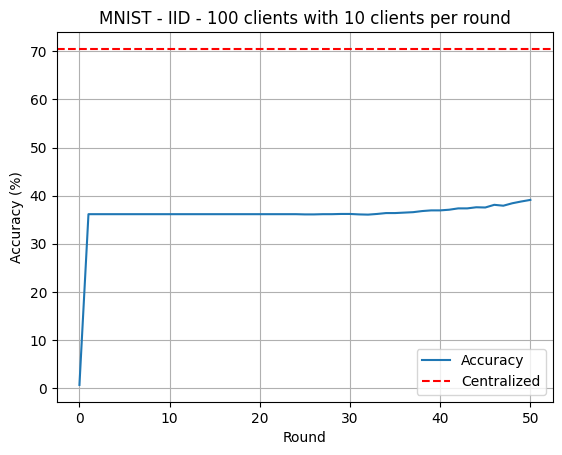

In [57]:
# Assuming `history.metrics_centralized` contains the data as described
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
rounds = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]

plt.plot(rounds, acc, label='Accuracy')
plt.axhline(y=70.5, color='r', linestyle='--', label='Centralized')
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")
plt.legend()

plt.show()